
# Landsat Tif Files in Python


In the previous lesson, you learned how to import a multi-band image into `Python` using
the `rasterio`. You then plotted the data as a composite, RGB (and CIR) image
using `imshow()` and calculated NDVI. 

In that case, all bands of the data were stored in a single `.tif` file. However, sometimes data are downloaded in individual bands rather
than a single file.

In this lesson you will learn how to work with Landsat data in `Python`. Each band in a landsat scene is often stored in an individual `.tif` file.  Thus you will need to grab the bands that you want to work with and then bring them into a `numpy` array. 

## About Landsat Data

> At over 40 years, the Landsat series of satellites provides the longest temporal record of moderate resolution multispectral data of the Earth’s surface on a global basis. The Landsat record has remained remarkably unbroken, proving a unique resource to assist a broad range of specialists in managing the world’s food, water, forests, and other natural resources for a growing world population.  It is a record unmatched in quality, detail, coverage, and value. Source: <a href="https://landsat.usgs.gov/about-landsat" target="_blank">USGS</a>


<figure>
    <a href="https://www.earthdatascience.org/images/courses/earth-analytics/remote-sensing/TimelineOnlyForWebRGB.png">
    <img src="https://www.earthdatascience.org/images/courses/earth-analytics/remote-sensing/TimelineOnlyForWebRGB.png" alt="Landsat 40 year timeline source: USGS.">
    </a>
    <figcaption>The 40 year history of landsat missions. Source: USGS - <a href="https://landsat.usgs.gov/landsat-missions-timeline" target = "_blank">USGS Landsat Timeline</a>
    </figcaption>
</figure>

Landsat data are spectral and collected using a platform mounted on a satellite in space that orbits the earth. The spectral bands
and associated spatial resolution of the first 9 bands in the Landsat 8 sensor
are listed below.

#### Landsat 8 Bands

| Band | Wavelength range (nanometers) | Spatial Resolution (m) | Spectral Width (nm)|
|-------------------------------------|------------------|--------------------|----------------|
| Band 1 - Coastal aerosol | 430 - 450 | 30 | 2.0 |
| Band 2 - Blue | 450 - 510 | 30 | 6.0 |
| Band 3 - Green | 530 - 590 | 30 | 6.0 |
| Band 4 - Red | 640 - 670 | 30 | 0.03 |
| Band 5 - Near Infrared (NIR) | 850 - 880 | 30 | 3.0 |
| Band 6 - SWIR 1 | 1570 - 1650 | 30 | 8.0  |
| Band 7 - SWIR 2 | 2110 - 2290 | 30 | 18 |
| Band 8 - Panchromatic | 500 - 680 | 15 | 18 |
| Band 9 - Cirrus | 1360 - 1380 | 30 | 2.0 |

### Understand Landsat Data
When working with landsat, it is important to understand both the metadata and
the file naming convention. The metadata tell you how the data were processed,
where the data are from and how they are structured.

The file names, tell you what sensor collected the data, the date the data were collected, and more.

<a href="https://landsat.usgs.gov/what-are-naming-conventions-landsat-scene-identifiers" target="_blank">More about the Landsat file naming convention.</a>

<figure>
    <a href="https://www.earthdatascience.org/images/courses/earth-analytics/remote-sensing/Collection_FileNameDiffs.png">
    <img src="https://www.earthdatascience.org/images/courses/earth-analytics/remote-sensing/Collection_FileNameDiffs.png" alt="landsat file naming convention">
    </a>
    <figcaption>Landsat file names Source: USGS Landsat - <a href="https://landsat.usgs.gov/what-are-naming-conventions-landsat-scene-identifiers" target = "_blank">Landsat Scene Naming Conventions</a>
    </figcaption>
</figure>

### Landsat File Naming Convention

Landsat and many other satellite remote sensing data is named in a way that tells you a about:

* When the data were collected and processed
* What sensor was used to collect the data
* What satellite was used to collect the data.

And more. 

Here you will learn a few key components of the landsat 8 collection file name. The first scene that you work with below is named:

`LC080340322016072301T1-SC20180214145802`

First, we have LC08

* **L:** Landsat Sensor
* **C:** OLI / TIRS combined platform
* **08:** Landsat 8 (not 7)

* **034032:** The next 6 digits represent the path and row of the scene. This identifies the spatial coverage of the scene

Finally, you have a date. In your case as follows:

* **20160723:** representing the year, month and day that the data were collected.

The second part of the file name above tells you more about when the data were last processed. You can read more about this naming convention using the link below.

<a href="https://landsat.usgs.gov/what-are-naming-conventions-landsat-scene-identifiers" target="_blank">Learn more about Landsat 8 file naming conventions.</a>

As you work wtih these data, it is good to double check that you are working with the sensor (Landsat 8) and the time period that you intend. Having this information in the file name makes it easier to keep track of this as you process your data. 

## Open Landsat .tif Files in Python

Now that you understand the Landsat 8 Collection file naming conventions, you will bring the data into Python. To begin, load your libraries and set up your working directory.

In [1]:
import os
import numpy as np
# File manipulation
from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio as rio
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20

You will be working in the `landsat-collect` directory. Notice that the data in that directory are stored by individual band. Each file is a single geotiff (.tif) rather than one tif with all the bands which is what you worked with in the previous lesson with NAIP data.  

### Why Are Landsat Bands Stored As Individual Files?
 
Conventionally landsat was stored in a file format called HDF - hierarchical
data format. However that format, while extremely efficient, is a bit more
challenging to work with. In recent years USGS has started to make each band
of a landsat scene available as a `.tif` file. This makes it a bit easier to use
across many different programs and platforms.

The good news is that you already know how to work with .tif files in `Python`. You just need to learn how to batch process a series of `.tif` files to work with Landsat 8 Collections. 

## Generate a List of Files in Python
 
To begin, explore the Landsat files in your `cold-springs-fire` directory. Start with the data:

`data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/`


In [2]:
!ls data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/

LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif
LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif


Note that there is a crop directory. Landsat scenes are large. To make processing quicker for you as you learn, your instructor cropped the data to a smaller spatial extent. She also added the word `_crop` to the end of each file to ensure you know the data have been modified. 


Also notice that some of the layers are qualtiy assurance layers. Others have the word band in them. The layers with band in them are the reflectance data that you need to work with. 

To work with these files you will do the following

1.  You will generate a list of all files in the directory that contain the word **band** in the name. 
2. Loop through those layers to create a numpy array.

You will use the `glob` function and library to do this in Python. 


In [3]:
glob("data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/*")

['data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_201

### Grab Subsets of File Names Using File Names and Other Criteria 

ABove you generated a list of all files in the directory. However you may wnat to subset that list to only include

1. `.tif` files
2. `.tif` files that contain the word "band" in them

Note that it is important that the file **ends with** .tif. So we use the dollar sign at the end of our pattern to tell Python to only grab files that end with .tif.

`path/*.tif` will grab all files in the crop directory that end with the .tif extension. 

In [4]:
glob("data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/*.tif")

['data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_201

To only grab files containing the word band AND that end with .tif we use `*band*.tif`.
This tells python to look for the word band anywhere before the .tif extension AND anywhere within the file name. 


In [5]:
all_landsat_bands = glob(
    "data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/*band*.tif")
all_landsat_bands

['data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_201801

Now you have a list of all of the landsat bands in your landsat collections folder. You could chose to open each file individually using the `rio.open` (rasterio library) function.

Remember that Python uses 0 based indexing so band 3 is actually at index `[2]` not `[3]`.

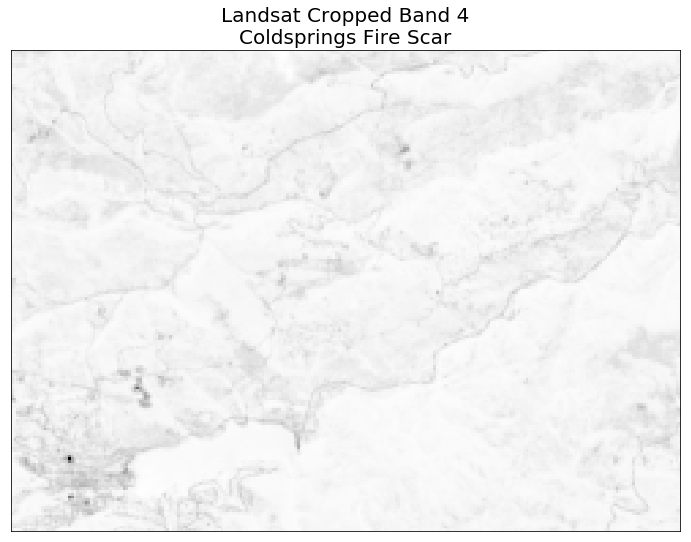

In [6]:
# Open a single band and plot
with rio.open(all_landsat_bands[3]) as src:
    landsat_band4 = src.read()

es.plot_bands(landsat_band4[0],
              title="Landsat Cropped Band 4\nColdsprings Fire Scar")

### Create Raster Stack of All Landsat Bands in Python

It's sometimes less efficient to import bands individually into Python. 
For this class, we have build a function that will create a new stacked tif file
from a list of tif files. This function takes 2 arguments:

1. a list of tif files that are all in the same crs and of the same extent
2. a path to a new file where the stacked raster will be saved

To call it you use the following:

`es.stack_raster_tifs(list-of-files-to-stack, "output/dir/filename.tif")`

Note that this stack function was written into the Earth Lab `earthpy` python package to avoid 
all of the steps that you would have to take to create the stack. In the next lesson we will break 
down how this function works in case you want to know. 

In [7]:
landsat_pre_fire_path = "data/cold-springs-fire/outputs/landsat_post_fire.tif"
# this will create a new stacked raster with all bands
land_stack, land_meta = es.stack_raster_tifs(all_landsat_bands,
                                             landsat_pre_fire_path)

#### Open The New Raster Stack 

Once you have stacked your data, you can import it and work with it as you need to!


In [8]:
with rio.open(landsat_pre_fire_path) as src:
    landsat_pre_fire = src.read()

```python
# calculate the total rows that will be required to plot each band 
# this could be a function too 
plot_rows = int(np.ceil(landsat_pre_fire.shape[0] / 3))
total_layers = landsat_pre_fire.shape[0]


# plot all bands
fig, axs = plt.subplots(plot_rows, 3, figsize=(15, 15))
axs_ravel = axs.ravel()
for ax, i in zip(axs_ravel, range(total_layers)):
    band = i+1
    ax.imshow(es.bytescale(landsat_pre_fire[i]), cmap='Greys')
    ax.set(title='Band %i' %band)
    ax.set(xticks=[], yticks=[])
# this loop clears out the plots for bands 8-9 which are empty
# but you have to populate them in matplotlib when you specify plot rows and cols
for ax in axs_ravel[total_layers:]:
   ax.set_axis_off()
   ax.set(xticks=[], yticks=[])
    
plt.tight_layout()
```

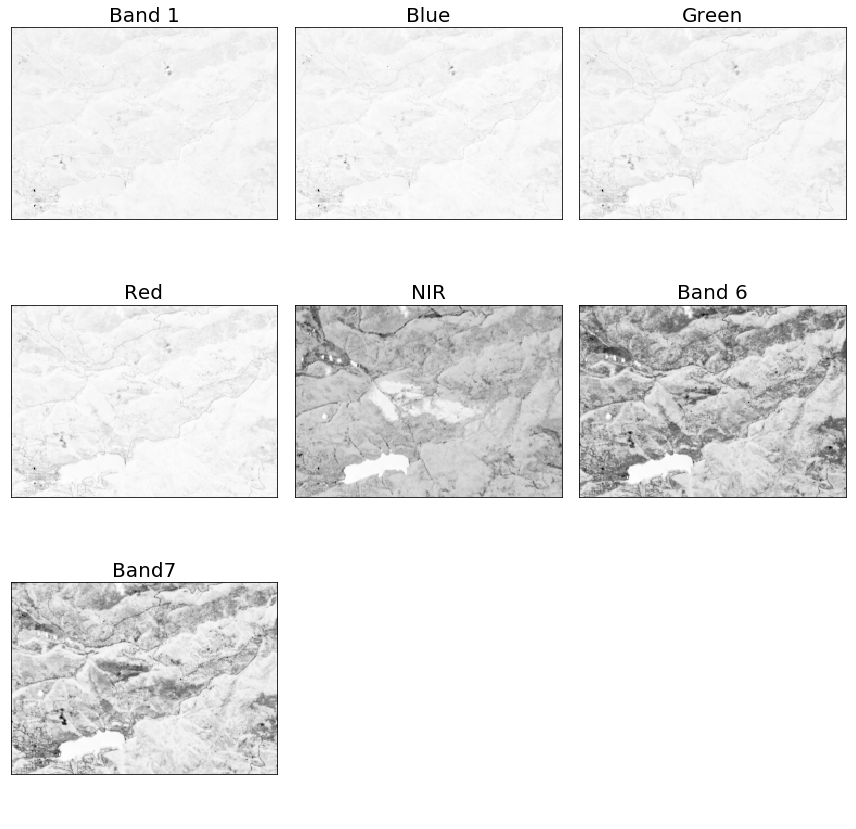

In [9]:
# Plot all bands using earthpy
band_titles = ["Band 1", "Blue", "Green", "Red", "NIR",
                     "Band 6", "Band7"]
es.plot_bands(landsat_pre_fire,
              title=band_titles)

## Plot RGB image

Just like you did with NAIP data, you can plot 3 band color composite images with Landsat too. Below you will plot an RGB image using landsat. Refer to the landsat bands in the table
at the top of this page to figure out the red, green and blue bands. Or read the
<a href="https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/" target="_blank">ESRI landsat 8 band combinations</a> post.


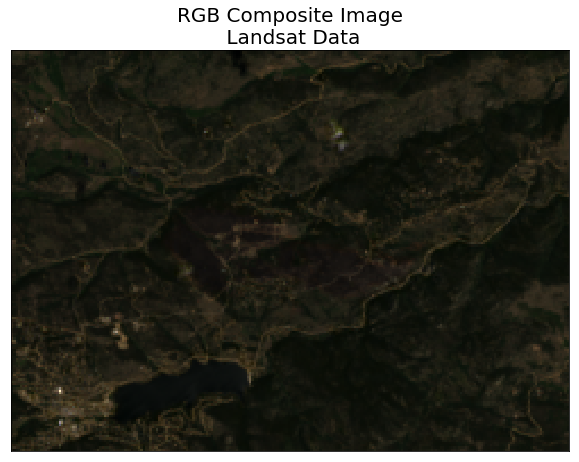

In [13]:
es.plot_rgb(landsat_pre_fire,
            rgb=[3, 2, 1],
            title="RGB Composite Image\n Landsat Data")

Notice that the image above looks dark. You can stretch the image as you did with the NAIP data, too.
Below you use the stretch argument built into the earthpy `plot_rgb()` function. The `str_clip` argument allows you to specify how much of the tails of the data that you want to clip off. The larger the number, the most the data will be stretched or brightened.

<figure>
    <a href="{{ site.url }}/images/courses/earth-analytics/raster-data/raster-image-stretch-dark.jpg">
    <img src="{{ site.url }}/images/courses/earth-analytics/raster-data/raster-image-stretch-dark.jpg" alt="When the range of pixel brightness values is closer to 0, a
    darker image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.">
    </a>
    <figcaption>When the range of pixel brightness values is closer to 0, a
    darker image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.
    </figcaption>
</figure>

<figure>
    <a href="{{ site.url }}/images/courses/earth-analytics/raster-data/raster-image-stretch-light.jpg">
    <img src="{{ site.url }}/images/courses/earth-analytics/raster-data/raster-image-stretch-light.jpg" alt="When the range of pixel brightness values is closer to 255, a
    lighter image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.">
    </a>
    <figcaption>When the range of pixel brightness values is closer to 255, a
    lighter image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.
    </figcaption>
</figure>

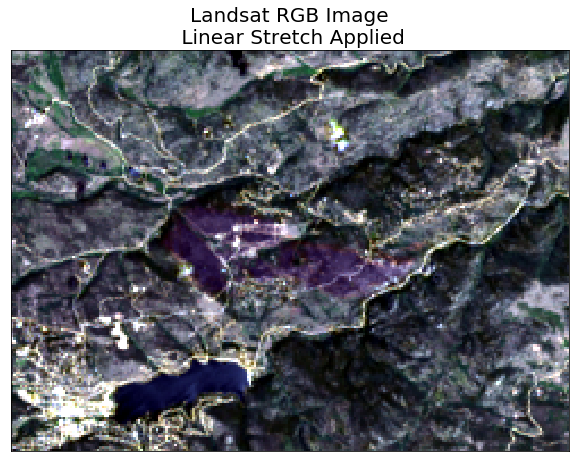

In [14]:
es.plot_rgb(landsat_pre_fire,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=1)

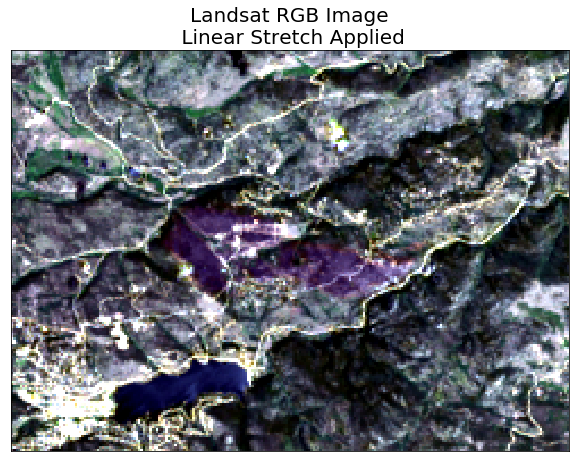

In [15]:
# Adjust the amount of linear stretch to futher brighten the image
es.plot_rgb(landsat_pre_fire,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=3)

## Raster Pixel Histograms

You can create a histogram to view the distribution of pixel values in the rgb bands plotted above. 

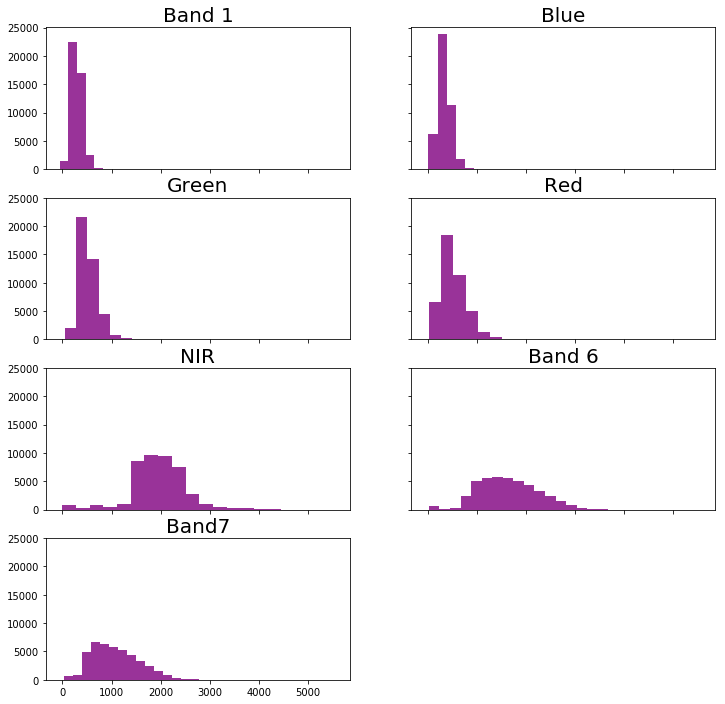

In [18]:
es.hist(landsat_pre_fire,
       title=band_titles)

Now you've created a red, green blue color composite image. Remember red green and blue are colors that
your eye can see. Create a color infrared image using landsat bands: 4,3,2.


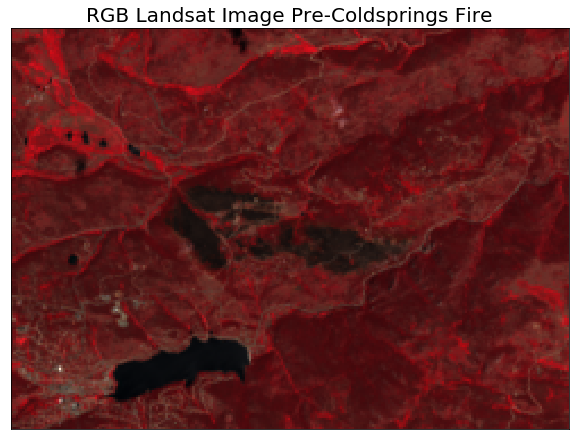

In [20]:
es.plot_rgb(landsat_pre_fire, rgb=[4, 3, 2],
            title="RGB Landsat Image Pre-Coldsprings Fire",
            figsize=(10,10))

<div class="notice--success" markdown="1">
<i class="fa fa-star"></i> **Data Tip:** Landsat 8 Pre Collections Data

If you are working with Landsat data downloaded pre USGS collections, your data may be formatted and named slightly differently than the example shown on this page. Below is an explanation of the legacy Landsat 8 naming convention. 

File: `LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif`

| Sensor | Sensor | Satellite | WRS path | WRS row | | | | |
|-------|
| L | C | 8 | 034| 032| 2016 |0707 | 20170221 | 01 |
| Landsat | OLI & TIRS | Landsat 8 | path = 034 | row = 032 | year = 2016 | Month = 7, day = 7 | Processing Date: 2017-02-21 (feb 21 2017) | Archive (second version): 01 |

* L: Landsat
* X: Sensor
  * C = OLI & TIRS
    O = OLI only
    T = IRS only
    E = ETM+
    T = TM
    M = MSS

* S Satelite
* PPP
* RRR
* YYYY = Year
* DDD = Julian DAY of the year
* GSI - Ground station ID
* VV = Archive Version

<a href="http://gisgeography.com/landsat-file-naming-convention/" target="_blank"> More here breaking down the file name.</a>

## Julian day

We won't spend a lot of time on Julian days. The julian day used to be used in Landsat pre collections file naming. However recently they have switched to a normal year-month-date format

There are several links at the bottom of this page that provide tables that help
you <a href="<a href="https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html" target="_blank">convert julian days to actual date</a>.


</div>